In [8]:
import torch
import numpy as np
from cryodrgn.source import ImageSource
from cryodrgn.lattice import Lattice, EvenLattice
from cryodrgn import lie_tools, shift_grid, so3_grid
from cryodrgn.pose_search import rot_2d, interpolate
from cryodrgn import fft
from proj_search import translate_images, rotate_images, optimize_theta_trans, optimize_theta_trans_chunked
import math

mrcs = ImageSource.from_file("../emdb_data/emd_1019_proj.mrcs")
images = mrcs.images()
images = images - images.mean(dim=(-1,-2), keepdim=True)

In [9]:
ref_images = images
query_images = ImageSource.from_file("../emdb_data/emd_1019_proj_noise.mrcs").images()
query_images = query_images - query_images.mean(dim=(-1,-2), keepdim=True)

trans = torch.tensor(shift_grid.base_shift_grid(0, 7, 7, xshift=0, yshift=0))
angles = torch.tensor(so3_grid.grid_s1(2), dtype=torch.float)

nquery = 100
query_idx = torch.randperm(images.shape[0])[:nquery]
trans_idx = torch.randint(trans.shape[0], (images.shape[0],))[:nquery]
rot_idx = torch.randint(angles.shape[0], (images.shape[0],))[:nquery]

trans_query = translate_images(query_images[query_idx], trans[trans_idx], input_hartley=False, output_hartley=False).diagonal().permute([2,0,1])
rottrans_query = rotate_images(trans_query, angles[rot_idx], input_hartley=False, output_hartley=False, fast_rotate=True).diagonal().permute([2,0,1]) # dumb


(INFO) (lattice.py) (13-Feb-25 00:00:05) Using circular lattice with radius=96
(INFO) (lattice.py) (13-Feb-25 00:00:13) Using circular lattice with radius=96


In [10]:
rottrans_query.shape

torch.Size([100, 192, 192])

(<Figure size 750x750 with 25 Axes>,
 array([[<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
         <AxesSubplot: >, <AxesSubplot: >],
        [<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
         <AxesSubplot: >, <AxesSubplot: >],
        [<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
         <AxesSubplot: >, <AxesSubplot: >],
        [<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
         <AxesSubplot: >, <AxesSubplot: >],
        [<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
         <AxesSubplot: >, <AxesSubplot: >]], dtype=object))

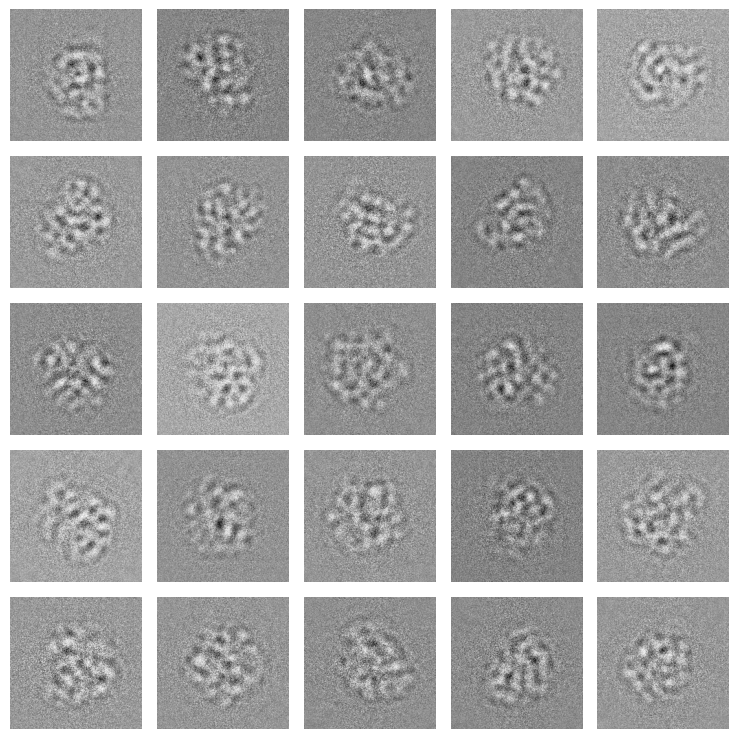

In [11]:
%matplotlib inline

from cryodrgn.analysis import plot_projections

#plot_projections(images)
plot_projections(rottrans_query)

In [ ]:
max_trans=14
best_corr, best_indices = optimize_theta_trans_chunked(images, rottrans_query, trans, angles, chunk_size=20, fast_translate=True, fast_rotate=True, max_trans=max_trans)
best_indices = torch.cat((best_indices[:,0].unsqueeze(1), -trans[best_indices[:,1]], ((math.pi - angles[best_indices[:,2]]) % (2 * math.pi)).unsqueeze(1)), dim=1)
best_indices

(INFO) (lattice.py) (13-Feb-25 00:00:32) Using circular lattice with radius=96


In [ ]:
print(torch.cat([query_idx.unsqueeze(1), trans[trans_idx], angles[rot_idx].unsqueeze(1)], dim=1))

In [ ]:
print((best_indices[:,0] == query_idx).sum() /  best_indices.shape[0])

In [7]:
best_indices[:,0] - query_idx

tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,   12.,    0.,    0.,    0.,    0.,
         -64.,    0.,    0.,    1.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,  -33.,   75.,    0.,    0.,    0.,    0.,    0.,
         -91.,   92.,    0.,    0.,    0.,    0.,    0.,   -1.,    0.,   -7.,
           0.,    0.,    0.,    0., -140.,    0.,    0.,    0.,    0.,   -1.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    3.,
           0.,    0.,    0.,    0.,  -73.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.])

In [16]:
import math
best_corr, best_indices = optimize_theta_trans_chunked(images, rottrans_query, trans, angles, chunk_size=20, fast_translate=False, fast_rotate=True)
best_indices = torch.cat((best_indices[:,0].unsqueeze(1), -trans[best_indices[:,1]], ((math.pi - angles[best_indices[:,2]]) % (2 * math.pi)).unsqueeze(1)), dim=1)
best_indices

(INFO) (lattice.py) (12-Feb-25 20:42:24) Using circular lattice with radius=96


tensor([[180.0000,  -2.0000,  -6.0000,   3.5343],
        [ 36.0000,   6.0000,  -2.0000,   0.9163],
        [ 97.0000,  -0.0000,   2.0000,   1.1781],
        [ 40.0000,  -4.0000,  -0.0000,   4.0579]])

(<Figure size 300x300 with 4 Axes>,
 array([[<AxesSubplot: >, <AxesSubplot: >],
        [<AxesSubplot: >, <AxesSubplot: >]], dtype=object))

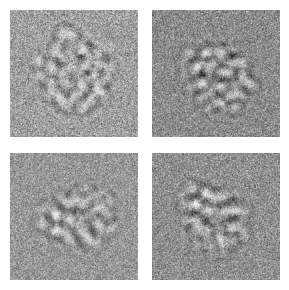

In [8]:
plot_projections(trans_query)

(INFO) (lattice.py) (12-Feb-25 20:41:30) Using circular lattice with radius=96


/tmp/ipykernel_7238/3342082227.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  zoomed_corr = torch.tensor(zoomed_corr)


tensor([[ 2, -7],
        [ 4,  2],
        [ 5,  6],
        [-6, -2]])
tensor([[ 2., -4.],
        [ 4.,  2.],
        [ 6.,  6.],
        [-2.,  0.]])


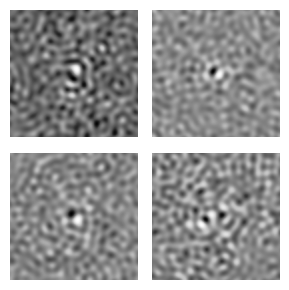

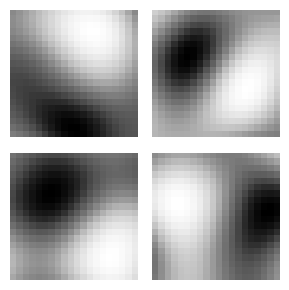

In [9]:
from scipy.ndimage import gaussian_laplace
import cv2

def sharpen_image(image, alpha=1.5, beta=-0.5):
    """Sharpen an image using an unsharp mask."""
    blurred = cv2.GaussianBlur(image, (0, 0), sigmaX=2)
    sharpened = cv2.addWeighted(image, alpha, blurred, beta, 0)
    return sharpened
    
#frequency filter mask
h, w = query_images.shape[-2:]
y, x = torch.meshgrid(torch.linspace(-1, 1, h+1), torch.linspace(-1, 1, w+1), indexing='ij')
radius = torch.sqrt(x**2 + y**2)


multiplier = 1

# rotate the query in hartley space 
trans_query = translate_images(query_images[query_idx], trans[trans_idx] * multiplier, input_hartley=False, output_hartley=False).diagonal().permute([2,0,1])
trans_ht = fft.ht2_center(trans_query)
trans_ht = fft.symmetrize_ht(trans_ht) * (radius < .15)

ref_ht = fft.ht2_center(ref_images[query_idx])
ref_ht = fft.symmetrize_ht(ref_ht) * (radius < .15)

cross_power = trans_ht * ref_ht  / (torch.abs(trans_ht * ref_ht) + 1e-8)
full_corr = fft.iht2_center(cross_power[...,:-1,:-1])

max_trans=20 * multiplier
start = (full_corr.shape[-1] - max_trans) // 2
end = start + max_trans
zoomed_corr = torch.tensor(sharpen_image(full_corr[..., max(0,start):end, max(0,start):end].numpy()))
zoomed_corr = torch.tensor(zoomed_corr)

plot_projections(full_corr)
plot_projections(zoomed_corr)

maxidx = zoomed_corr.reshape(zoomed_corr.shape[:-2] + (-1,)).argmax(dim=-1)
yshift, xshift = torch.unravel_index(maxidx, (max_trans, max_trans))
shifts = torch.stack([xshift - max_trans // 2, yshift - max_trans // 2], dim=1)
print(shifts)
print(trans[trans_idx] * multiplier)


(INFO) (lattice.py) (12-Feb-25 12:28:56) Using circular lattice with radius=96
tensor([[-77, -51],
        [-47, -36],
        [-57, -51],
        [ 83, -67]])
tensor([[-20.,   0.],
        [-40.,  20.],
        [ 40.,   0.],
        [-20.,  20.]])


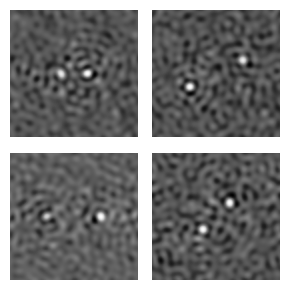

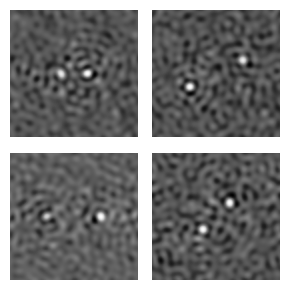

In [148]:
#frequency filter mask
h, w = query_images.shape[-2:]
y, x = torch.meshgrid(torch.linspace(-1, 1, h+1), torch.linspace(-1, 1, w+1), indexing='ij')
radius = torch.sqrt(x**2 + y**2)


multiplier = 10

# rotate the query in hartley space 
trans_query = translate_images(ref_images[query_idx], trans[trans_idx] * multiplier, input_hartley=False, output_hartley=False).diagonal().permute([2,0,1])
trans_ht = fft.ht2_center(trans_query)
trans_ht = fft.symmetrize_ht(trans_ht) * (radius < .15)

ref_ht = fft.ht2_center(ref_images[query_idx])
ref_ht = fft.symmetrize_ht(ref_ht) * (radius < .15)

cross_power = trans_ht * ref_ht  / (torch.abs(trans_ht * ref_ht) + 1e-8)
full_corr = fft.iht2_center(cross_power[...,:-1,:-1])

max_trans=25 * multiplier
start = (full_corr.shape[-1] - max_trans) // 2
end = start + max_trans
zoomed_corr = full_corr[..., max(0,start):end, max(0,start):end] # M x N x R x 30 x 30

plot_projections(full_corr)
plot_projections(zoomed_corr)

maxidx = zoomed_corr.reshape(pairwise_corr.shape[:-2] + (-1,)).argmax(dim=-1)
yshift, xshift = torch.unravel_index(maxidx, (max_trans, max_trans))
shifts = torch.stack([xshift - max_trans // 2, yshift - max_trans // 2], dim=1)
print(shifts)
print(trans[trans_idx] * multiplier)

(<Figure size 300x300 with 4 Axes>,
 array([[<AxesSubplot: >, <AxesSubplot: >],
        [<AxesSubplot: >, <AxesSubplot: >]], dtype=object))

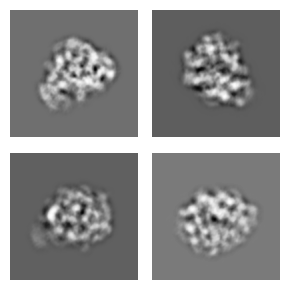

In [38]:
plot_projections(ref_images[query_idx])

(<Figure size 300x300 with 4 Axes>,
 array([[<AxesSubplot: >, <AxesSubplot: >],
        [<AxesSubplot: >, <AxesSubplot: >]], dtype=object))

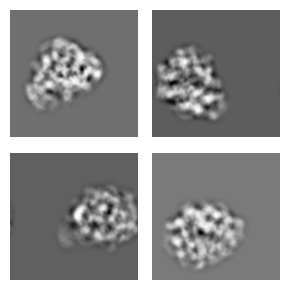

In [39]:
plot_projections(control_trans)

In [47]:
trans[trans_idx] * 10

tensor([[-20.,   0.],
        [-40.,  20.],
        [ 40.,   0.],
        [-20.,  20.]])

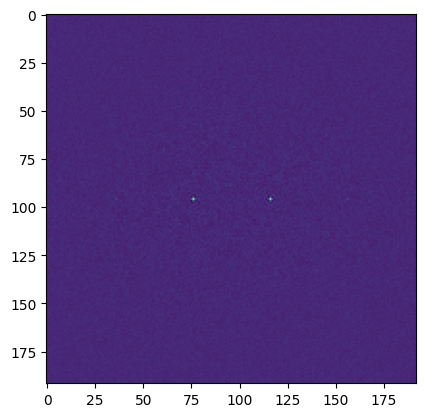

In [63]:
import matplotlib.pyplot as plt
plt.imshow(full_corr[0])

In [85]:
(radius < .2).sum()

tensor(1153)

In [10]:
z = torch.randn([3,4,5,6])

In [13]:
z.amax(dim=-1)

tensor([[[ 1.4347,  0.0165,  1.7444,  0.3944,  1.2916],
         [ 1.0025,  2.0434,  2.1097,  3.7815,  1.1526],
         [ 1.6122,  0.7393,  0.5762,  0.1176,  1.2201],
         [ 2.0432,  1.0879,  1.5988,  1.3167,  1.3625]],

        [[ 2.1013,  1.6809,  1.1953,  1.0602,  1.6706],
         [ 1.8376,  1.1863,  0.8465,  0.4972,  1.3717],
         [ 0.0695,  1.4454, -0.2993,  2.4214,  1.3323],
         [ 1.4622,  0.7009,  0.7909,  0.3197,  2.8007]],

        [[ 1.4751,  1.4333,  1.0971,  0.8197,  1.8789],
         [ 1.2600,  0.8515,  1.8108,  1.4451,  0.7983],
         [ 0.7946,  1.2683,  0.4008,  0.6765,  0.4895],
         [ 1.3176,  1.8430,  0.7000,  0.9901,  1.8476]]])